In [84]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000                     # true flux, say number of photons measured in 1 second
N = 50                        # number of measurements
F = stats.chi2(F_true).rvs(N)      # N measurements of the flux
e = np.sqrt(F)                    # errors on Poisson counts estimated via square root

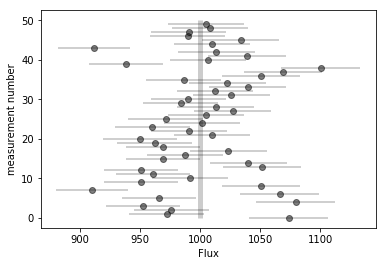

In [85]:
# show the results
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");
plt.show()

In [86]:
# estimate the f value
estimated_f = (e**2 * F).sum() / (e**2).sum()
print('Ground Truth f : ', F_true)
print('Estimated f    : ', estimated_f)
print("Error Bound +/-: ",  (1./e**2).sum() ** -0.5)

Ground Truth f :  1000
Estimated f    :  1002.8654341692877
Error Bound +/-:  4.470687512531004


# Reference
1. scipy.stats.chi2 — SciPy v1.1.0 Reference Guide. (2018). Docs.scipy.org. Retrieved 13 November 2018, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2
2. 